# Lab 7 : Clustering
Summary :
1. Load the dataset into a feature matrix (gray images, resizing and normalization), and the three channels (B, G, R)
2. K-means
3. Image segmentation

# 1. Load the dataset (X and Y vector)

In [1]:
import os
import numpy as np
import cv2
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
import pandas as pd
import seaborn as sns 

DATASET_PATH = '../data/Fish_Dataset/Fish_Dataset/'

In [12]:
def get_labels():
    folders = os.listdir(DATASET_PATH)
    labels = []
    for f in folders:
        if not('.m' in f) and not('.txt' in f):
            labels.append(f)
    labels = np.array(labels)
    return labels


def get_X_Y_RGB(labels):
    # Get the images for each label
    img_shape = (128, 128) #resizing images to this shape ( after converting color image to gray image)
    n_sample_per_class = 600 #Keep only this number of samples per class (expensive complexity issue)
    nb_img = n_sample_per_class*len(labels) #1000 images per class

    X = np.zeros((nb_img, img_shape[0]*img_shape[1])) #feature matrix
    X_B = np.zeros((nb_img, img_shape[0]*img_shape[1])) # feature matrix
    X_G = np.zeros((nb_img, img_shape[0]*img_shape[1])) # feature matrix
    X_R = np.zeros((nb_img, img_shape[0]*img_shape[1])) # feature matrix
    Y = np.zeros(nb_img) #labels vector
    for i in range(len(labels)):
        folder = os.path.join(DATASET_PATH, labels[i], labels[i])
        images = os.listdir(folder)
        np.random.shuffle(images)
        for j in range(n_sample_per_class):
            img_path = os.path.join(folder, images[j])
            img = cv2.imread(img_path) #Load the gray image
            img = cv2.medianBlur(img, 9) #Median filter
            #Resizing
            img_B = cv2.resize(src=img[:,:,0], dsize=img_shape)/255
            img_G = cv2.resize(src=img[:,:,1], dsize=img_shape)/255
            img_R = cv2.resize(src=img[:,:,2], dsize=img_shape)/255
            img = cv2.cvtColor(src=img, code=cv2.COLOR_BGR2GRAY)
            img = cv2.resize(src=img, dsize=img_shape)/255

            #Add the image in the feature matrix and its labels to the label vector
            X_B[i*n_sample_per_class+j, :] = img_B.flatten()
            X_G[i*n_sample_per_class+j, :] = img_G.flatten()
            X_R[i*n_sample_per_class+j, :] = img_R.flatten()
            X[i*n_sample_per_class+j, :] = img.flatten()
            Y[i*n_sample_per_class+j] = np.argwhere(labels==labels[i])[0]
    return X, X_B, X_G, X_R, Y

labels = get_labels()
X, X_B, X_G, X_R, Y = get_X_Y_RGB(labels)
print("Feature matrix : \n", X)
print("Label vector : \n", Y)

#X_train, X_test, y_train, y_test = train_test_split(X, Y, random_state=42)

Feature matrix : 
 [[0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 ...
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.         0.         0.         ... 0.         0.         0.        ]
 [0.29019608 0.36078431 0.36470588 ... 0.76470588 0.84705882 0.72156863]]
Label vector : 
 [0. 0. 0. ... 8. 8. 8.]


# 2. K_means

In [4]:
# Pipeline
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import set_config
from sklearn.cluster import KMeans

# Scoring
from sklearn.metrics import roc_auc_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
# PCA
from sklearn.decomposition import PCA

In [5]:

set_config(display="diagram")
n_components = 3
pca = PCA(n_components=n_components)
X_pca = pca.fit_transform(X)


### Visualize the 3 most correlated features of the datasets regards to their labels

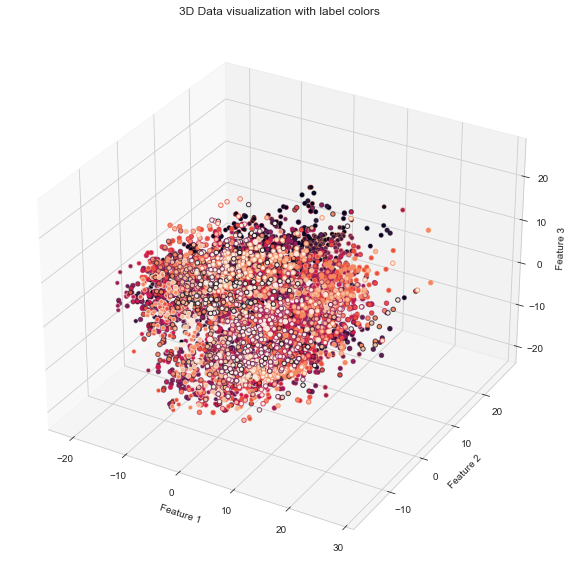

In [9]:
fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
plt.title('3D Data visualization with label colors')
ax.scatter3D(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=Y)
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

### Visualize the 3 most correlated features of the datasets regards to their clusters (after k-means)

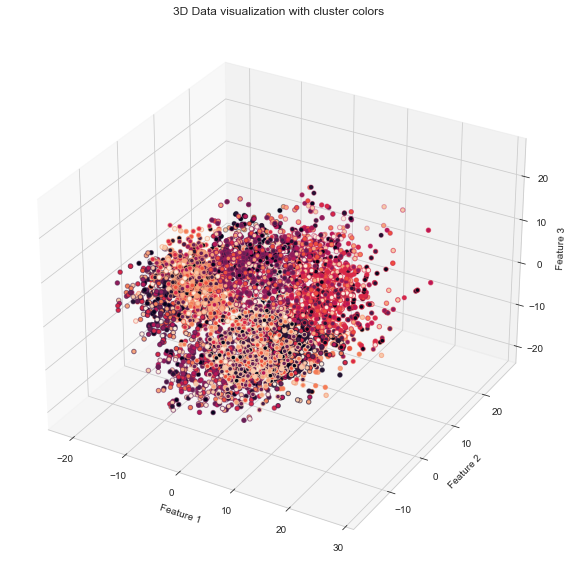

In [10]:
n = 12
kmeans = KMeans(n_clusters=n, random_state=42)
y_pred = kmeans.fit_predict(X_pca)

fig = plt.figure(figsize=(10,10))
ax = plt.axes(projection='3d')
ax.scatter3D(X_pca[:,0], X_pca[:,1], X_pca[:,2], c=y_pred)
plt.title('3D Data visualization with cluster colors')
ax.set_xlabel('Feature 1')
ax.set_ylabel('Feature 2')
ax.set_zlabel('Feature 3')
plt.show()

Confusion matrix of the 12 clusters regards to the 9 true labels :

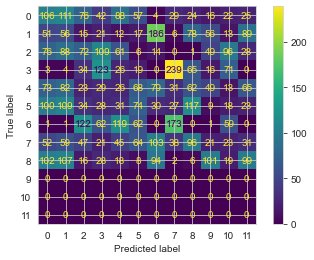

In [11]:
confMat = confusion_matrix(Y, y_pred, labels=np.arange(0, n))
confMat_display = ConfusionMatrixDisplay(confMat, display_labels=np.arange(0, n))
confMat_display.plot()

------------------------------
Kmeans : 2 clusters


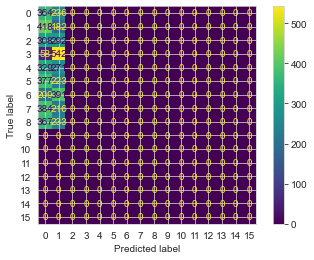

------------------------------
Kmeans : 4 clusters


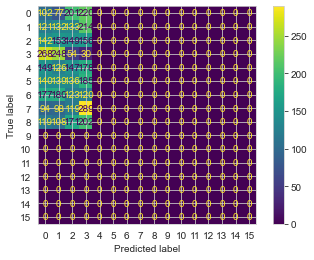

------------------------------
Kmeans : 6 clusters


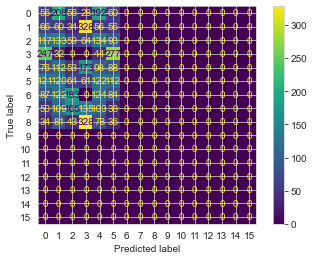

------------------------------
Kmeans : 9 clusters


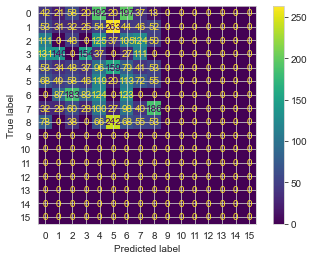

------------------------------
Kmeans : 14 clusters


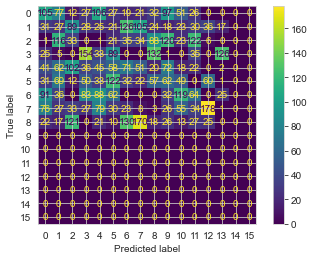

------------------------------
Kmeans : 15 clusters


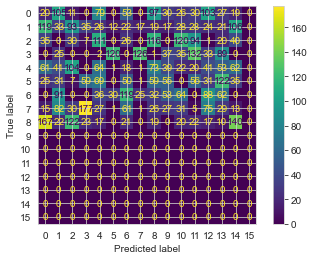

In [8]:
n_clusters = [6, 9, 12, 14, 15]
for n in range(len(n_clusters)):
    kmeans = KMeans(n_clusters=n_clusters[n])
    y_pred = kmeans.fit_predict(X, Y)
    print('---'*10)
    print('Kmeans : {} clusters'.format(n_clusters[n]))
    confMat = confusion_matrix(Y, y_pred, labels=np.arange(0, np.max(n_clusters)))
    confMat_display = ConfusionMatrixDisplay(confMat, display_labels=np.arange(0, np.max(n_clusters)))
    confMat_display.plot()
    plt.show()

## K means for image segmentation before classifcation:
K_means for each image (we search to classify the pixels)

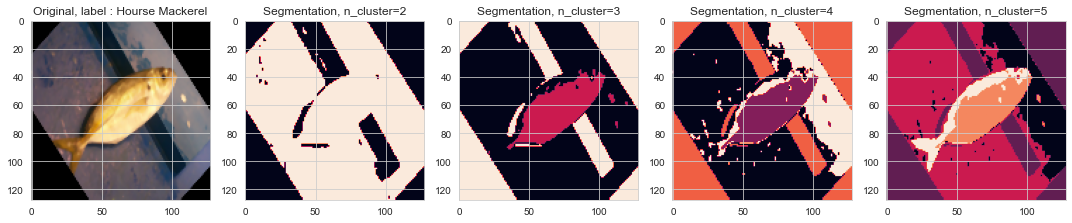

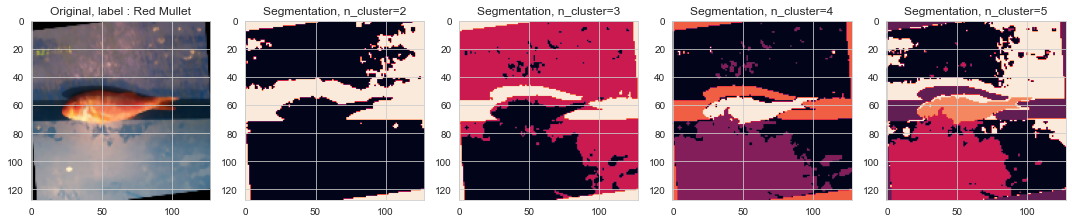

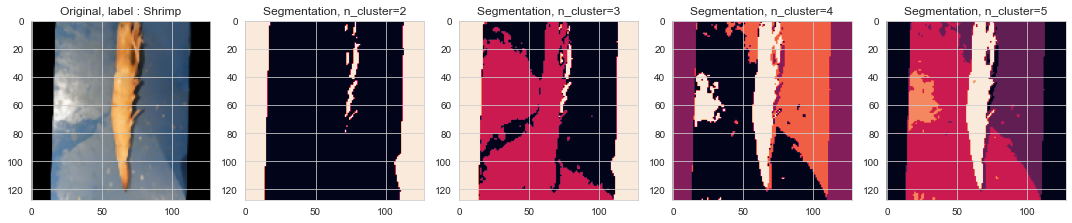

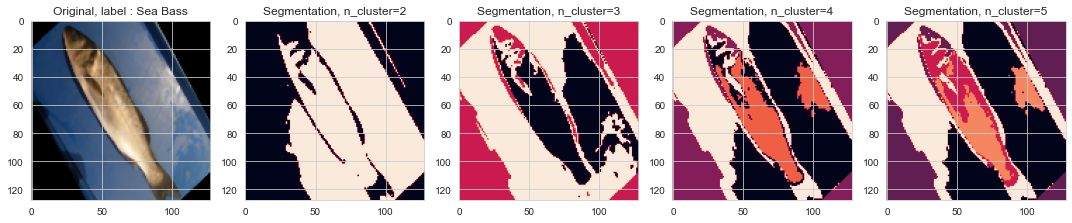

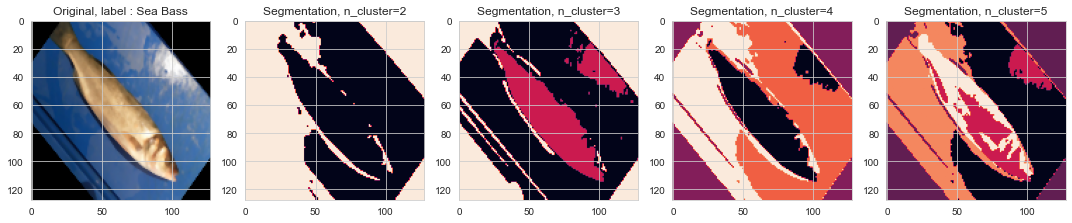

In [22]:
n_samples = 5
n_clusters = [2, 3, 4, 5]

img_shape = (128, 128, 3)

for i in range(n_samples):
    idx = np.random.randint(0, X_B.shape[0])
    #print(X_R[idx,:].T.shape)
    img = np.concatenate((X_R[idx,:].T[:, None], X_G[idx,:].T[:, None], X_B[idx, :].T[:, None]), axis=1)
    plt.figure(figsize=(15,10))
    plt.subplot(1,len(n_clusters)+1,1)
    img_origin = img.reshape(img_shape)
    plt.imshow(img_origin, cmap='gray')
    plt.title('Original, label : {}'.format(labels[int(Y[idx])]))
    for n in range(len(n_clusters)):
        kmeans = KMeans(n_clusters=n_clusters[n], algorithm='elkan', random_state=0)
        img_pred = kmeans.fit_predict(img)
        plt.subplot(1,len(n_clusters)+1, n+2)
        plt.imshow(img_pred.reshape((128,128)))
        plt.title('Segmentation, n_cluster={}'.format(n_clusters[n]))
    plt.tight_layout()

In [14]:
import datetime
def dataset_segmentation(X_B, X_G, X_R, Y, n_cluster, n_samples):
    t0 = datetime.datetime.now()
    idx_segm = np.random.randint(0, X_B.shape[0], n_samples)
    X_segm = np.zeros((n_samples, 128*128))
    X_B_segm = X_B[idx_segm][:]
    X_G_segm =  X_G[idx_segm][:]
    X_R_segm =  X_R[idx_segm][:]
    Y_segm = Y[idx_segm]
    for i in range(n_samples):
        kmean = KMeans(n_clusters=n_cluster, algorithm='elkan', random_state=0)
        img_or = np.concatenate((X_R_segm[i,:].T[:, None], X_G_segm[i,:].T[:, None], X_B_segm[i, :].T[:, None]), axis=1)
        img_segm = kmean.fit_predict(img_or)
        X_segm[i, :] = img_segm.T
    tf = datetime.datetime.now() - t0
    print('Segmentation time(hh:mm:ss) : {}'.format(tf))
    return X_segm, Y_segm

In [15]:
n_cluster = 3
n_samples = 3500

#X_segm_3, Y_segm_3 = dataset_segmentation(X_B, X_G, X_R, Y, n_cluster=3, n_samples=n_samples)
X_segm_2, Y_segm_2 = dataset_segmentation(X_B, X_G, X_R, Y, n_cluster=2, n_samples=n_samples)


Segmentation time(hh:mm:ss) : 0:08:14.601665


In [24]:
n_samples = 3500
X_segm_4, Y_segm_4 = dataset_segmentation(X_B, X_G, X_R, Y, n_cluster=4, n_samples=n_samples)

Segmentation time(hh:mm:ss) : 0:15:38.183826


In [20]:
n_samples = 3500
X_segm_5, Y_segm_5 = dataset_segmentation(X_B, X_G, X_R, Y, n_cluster=5, n_samples=n_samples)

Segmentation time(hh:mm:ss) : 0:18:31.898638


In [21]:
#print(X_segm_3.shape)
#print(Y_segm_3.shape)

In [16]:
from sklearn import svm
from sklearn.model_selection import train_test_split
import datetime
def apply_SVM_model(X, Y):
    X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=0)

    t0 = datetime.datetime.now()
    model = svm.SVC(random_state=0)
    model.fit(X_train, y_train)
    tf = datetime.datetime.now() - t0
    print('Training time : {}'.format(tf))

    y_pred = model.predict(X_test)
    print('Evaluation on the test data set :')
    class_report = classification_report(y_test, y_pred)
    print(class_report)
    confMat = confusion_matrix(y_test, y_pred, labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    confMat_display = ConfusionMatrixDisplay(confMat, display_labels=[0, 1, 2, 3, 4, 5, 6, 7, 8])
    confMat_display.plot()
    return  model, class_report



With 2 clusters:

Training time : 0:10:47.615426
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.73      0.81      0.77       139
         1.0       0.58      0.55      0.57       121
         2.0       0.74      0.66      0.70       119
         3.0       0.75      0.76      0.76       121
         4.0       0.76      0.65      0.70       141
         5.0       0.63      0.79      0.70       136
         6.0       0.76      0.82      0.79       117
         7.0       0.69      0.64      0.66       137
         8.0       0.69      0.65      0.67       124

    accuracy                           0.70      1155
   macro avg       0.70      0.70      0.70      1155
weighted avg       0.70      0.70      0.70      1155



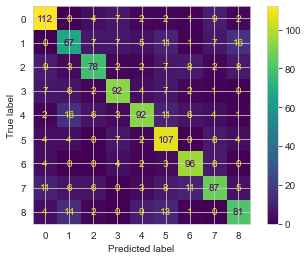

In [17]:
model2, class_report2 = apply_SVM_model(X_segm_2, Y_segm_2)

With 3 clusters:

Training time : 0:05:24.482001
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.61      0.35      0.44        66
         1.0       0.38      0.35      0.36        75
         2.0       0.38      0.59      0.46        82
         3.0       0.44      0.69      0.54        68
         4.0       0.47      0.31      0.37        68
         5.0       0.27      0.31      0.29        75
         6.0       0.45      0.42      0.43        72
         7.0       0.52      0.43      0.47        81
         8.0       0.48      0.37      0.42        73

    accuracy                           0.42       660
   macro avg       0.44      0.42      0.42       660
weighted avg       0.44      0.42      0.42       660



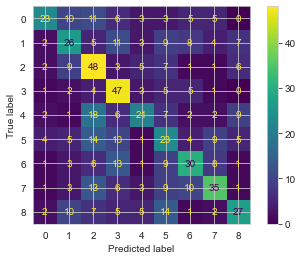

In [ ]:
#model3, class_report3 = apply_SVM_model(X_segm_3, Y_segm_3)

With 4 clusters :

Training time : 0:15:32.796033
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.43      0.71      0.54       114
         1.0       0.59      0.57      0.58       130
         2.0       0.55      0.69      0.61       140
         3.0       0.66      0.61      0.64       129
         4.0       0.69      0.40      0.51       127
         5.0       0.51      0.63      0.57       131
         6.0       0.68      0.66      0.67       124
         7.0       0.69      0.47      0.56       120
         8.0       0.69      0.53      0.60       140

    accuracy                           0.59      1155
   macro avg       0.61      0.59      0.59      1155
weighted avg       0.61      0.59      0.59      1155



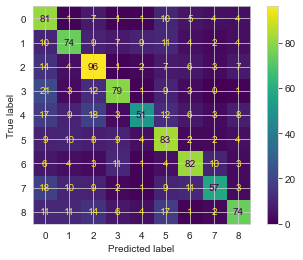

In [25]:
model4, class_report4 = apply_SVM_model(X_segm_4, Y_segm_4)

With 5 clusters:

Training time : 0:15:05.827849
Evaluation on the test data set :
              precision    recall  f1-score   support

         0.0       0.61      0.59      0.60       135
         1.0       0.56      0.54      0.55       145
         2.0       0.60      0.54      0.57       142
         3.0       0.61      0.64      0.62       128
         4.0       0.52      0.66      0.58       116
         5.0       0.59      0.61      0.60       104
         6.0       0.60      0.67      0.63       118
         7.0       0.65      0.51      0.57       129
         8.0       0.66      0.63      0.65       138

    accuracy                           0.60      1155
   macro avg       0.60      0.60      0.60      1155
weighted avg       0.60      0.60      0.60      1155



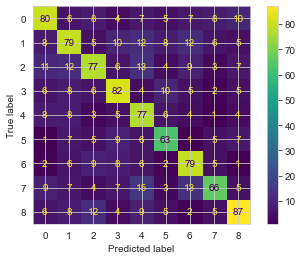

In [21]:
model5, class_report5 = apply_SVM_model(X_segm_5, Y_segm_5)